Two porcine subjects were scanned in a GE 1.5T MR scanner. Active catheter tracking data was acquired using the Hadamard-multiplexed sequence for approximately 5 seconds as the catheter was held against the wall of the left ventricle, for a total of 12 locations across subjects.

Respiratory and cardiac motion will be reflected in these recordings and no ground truth data exists, so we will look at the spread of the points using:
- the distances to the centroids
- the angles between the catheter tip and the mean orientation

We will also look at how smooth these recordings are using:
- the distances between successive tip locations
- the angles between successive catheter tip orientations

In [22]:
import displacement_utils
import pandas as pd
from catheter_utils import cathcoords
from catheter_utils import geometry
from catheter_utils import projections
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pathlib import Path
from collections import OrderedDict
import os

In [23]:
from itertools import chain

In [24]:
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [25]:
plt.rcParams['figure.figsize'] = [20, 15]
pd.options.display.max_columns = None

In [26]:
# Localization algorithms of interest
sel_algos = displacement_utils.select_algos
shorten = {'centroid_around_peak':'cap','jpng':'jpng'}

In [ ]:
export_path = '/code/reports/export/invivo'
figure_path = '/code/reports/figures/invivo'

Path(export_path).mkdir(parents=True,exist_ok=True)
Path(figure_path).mkdir(parents=True,exist_ok=True)

# Read in tracked locations from both experiments
This assumes the raw projection data has already been reconstructed and the tracking coils have been localized using the peak-finding algorithms: this can be done using the top-level notebook with output stored in a directory named "processed". If this directory is not found, preprocessed coordinates (stored in a directory named "preprocessed") are used. The coordinates have been saved to text files.

In [28]:
ablationsDF = pd.read_csv('experiment_recordings.csv')

In [29]:
ablationsDF['Experiment Name'] = ablationsDF.apply(lambda x: Path(x['Input']).parts[-2].replace('_',' '), axis=1)
ablationsDF['Description'] = ablationsDF.apply(lambda x: Path(x['Input']).parts[-1].replace('_',' '), axis=1)

In [30]:
experiments = ablationsDF['Experiment Name'].unique()

In [31]:
prepend = '/data/'
preprocessed = False
if not os.path.isdir(prepend+'processed'):
    prepend = '../data/'
    preprocessed = True

In [32]:
def get_cathcoords_path(folder, coil_index):
    cathcoord_files = cathcoords.discover_files(folder)
    if (bool(cathcoord_files)):
        return cathcoord_files[0][coil_index]
    else:
        return None

In [33]:
def get_processed_path(raw_path,prepend,preprocessed=False):
    proc_string = 'preprocessed' if preprocessed else 'processed'
    return (prepend + raw_path + '/').replace('raw',proc_string)

In [34]:
def get_recording_index(folder):
    algo = displacement_utils.select_algos[0]
    cath_files = cathcoords.discover_files(folder+algo)
    if bool(cath_files):
        return list(cath_files.keys())[0]
    else:
        return None

In [35]:
ablationsDF['Coord_folder'] = ablationsDF.apply(lambda x: get_processed_path(x['Input'],prepend,preprocessed),axis=1)

In [36]:
ablationsDF['Recording_index'] = ablationsDF.apply(lambda x: get_recording_index(x['Coord_folder']),axis=1)

# Distances from the centroid: Centroid-about-peak vs JPNG

In [37]:
ablationsDF[['coords','fits','displacements','centroids']] = ablationsDF.apply(lambda x: 
                                                                   displacement_utils.get_locs_displacements(str(x['Coord_folder']),
                                                                                                             cathcoords.make_filename(x['Recording_index'],x['distal']),
                                                                                                             cathcoords.make_filename(x['Recording_index'],x['proximal']),
                                                                                                             geometry.GEOMETRY[1], selected_algos=displacement_utils.select_algos),
                                                                               axis=1, result_type='expand' )

In [38]:
ablationsDF['msecs'] = ablationsDF.apply(lambda x: displacement_utils.getMsecsSinceStart(x['coords'][displacement_utils.select_algos[0]][0]), axis=1)

In [39]:
stats_cols = []

In [40]:
summary_stat_cols = []

In [41]:
for algo in displacement_utils.select_algos:
    colName = 'tips_' + algo
    ablationsDF[colName] = ablationsDF.apply(lambda x: x['fits'][algo].tip,axis=1)

In [42]:
for algo in displacement_utils.select_algos:
    colName = 'displacements_' + algo
    ablationsDF[colName] = ablationsDF.apply(lambda x: x['displacements'][algo],axis=1)

In [43]:
for algo in displacement_utils.select_algos:
    colName = 'mean_disp_' + algo
    stats_cols.append(colName)
    ablationsDF[colName] = ablationsDF.apply(lambda x: np.mean(x['displacements_' + algo]),axis=1)

In [44]:
for algo in displacement_utils.select_algos:
    colName = 'mean_dist_' + algo
    summary_stat_cols.append(colName)
    ablationsDF[colName] = ablationsDF.apply(lambda x: np.mean(x['displacements_' + algo]),axis=1)
    colName = 'std_'+algo
    summary_stat_cols.append(colName)

In [45]:
for algo in displacement_utils.select_algos:
    colName = 'variance_' + algo
    stats_cols.append(colName)
    ablationsDF[colName] = ablationsDF.apply(lambda x: np.var(x['displacements_' + algo], ddof=1),axis=1)
    colName = 'std_'+algo
    stats_cols.append(colName)
    ablationsDF[colName] = ablationsDF.apply(lambda x: np.std(x['displacements_' + algo], ddof=1),axis=1)

In [46]:
for algo in displacement_utils.select_algos:
    colName = 'IQR_' + algo
    stats_cols.append(colName)
    ablationsDF[colName] = ablationsDF.apply(lambda x: np.subtract(*np.percentile(x['displacements_' + algo], [75, 25])),axis=1)

In [47]:
# interquartile range
for algo in displacement_utils.select_algos:
    colName = 'median_disp_' + algo
    stats_cols.append(colName)
    ablationsDF[colName] = ablationsDF.apply(lambda x: np.median(x['displacements_' + algo]),axis=1)
    colName = 'MAD_disp_' + algo
    stats_cols.append(colName)
    ablationsDF[colName] = ablationsDF.apply(lambda x: stats.median_absolute_deviation(x['displacements_' + algo],
                                                                                                 scale=1.0),
                                                        axis=1)

In [48]:
ablDF = ablationsDF.drop(['coords','fits'],axis=1)

In [49]:
sel_algos = displacement_utils.select_algos

In [50]:
ablationsDF['count'] = ablationsDF.apply(lambda x: len(x['displacements'][sel_algos[0]]), axis=1)
stats_cols.append('count')

In [51]:
for algo in sel_algos:
    ablationsDF[algo+'_tipCoords'] = ablationsDF.apply(lambda x: x['fits'][algo].tip, axis=1)

In [52]:
ablationsDF = ablationsDF.drop(['fits'],axis=1)

In [53]:
ablationsDF.to_hdf(export_path + '/ablationAllCoordsDF.hdf5',key='ablCoords')

In [54]:
def displacement_plot(experiment_name, description, msecs, displacements, show=False):
    plot = displacement_utils.plot_displacements(msecs,displacements)
    title = experiment_name + ': ' + description
    plot.title(title)
    plot.savefig(figure_path + '/' +title+'.png')
    if show:
        plot.show()
    else:
        plot.close()

These plot the distance to centroid over the lengths of the recordings, one plot for each recording. These are saved to files: to see them inline, set ``show=True`` in the displacement_plot call below.

In [55]:
out = ablDF.apply(lambda x: displacement_plot(x['Experiment Name'], x['Description'], x['msecs'],\
                                              x['displacements'], show=False),axis=1)

In [56]:
def print_disp_stats(experiment_name, description, displacements):
    print('**** Experiment: ' + experiment_name + ' Recording: ' + description + ' ****')
    displacement_utils.print_displacement_stats(displacements)

## Additional plots and tables for distances from the centroid

In [57]:
abl_df = ablDF.rename(columns={'Experiment Name':'expmt'})
subj_recording = OrderedDict()

for row in abl_df.itertuples():
    subject = row.expmt
    description = row.Description
    if subject in subj_recording.keys():
        subj_recording[subject].append(description)
    else:
        subj_recording[subject] = [description]

In [58]:
abl_df['Subject'] = abl_df.apply(lambda x: list(subj_recording.keys()).index(x['expmt']), axis=1)
ablDF['Subject'] = ablDF.apply(lambda x: list(subj_recording.keys()).index(x['Experiment Name']), axis=1)

In [59]:
abl_df['Recording'] = abl_df.apply(lambda x: subj_recording[x['expmt']].index(x['Description']), axis=1)
ablDF['Recording'] = ablDF.apply(lambda x: subj_recording[x['Experiment Name']].index(x['Description']), axis=1)

In [60]:
def displacement_box_plot(experiment_name, description, displacements, algos=displacement_utils.select_algos, axis=None):
    plot = None
    if axis is None:
        plot = displacement_utils.plot_displacement_boxplot(displacements, selected_algos = algos)
    else:
        plot = displacement_utils.plot_displacement_boxplot(displacements, selected_algos = algos, plot=axis)
    title = experiment_name + ': ' + description
    if axis is None:
        plot.title(title)
        plot.savefig(figure_path+'/dispBoxPlot_'+title+'.png')
        plot.show()
    else:
        axis.set_title(title)

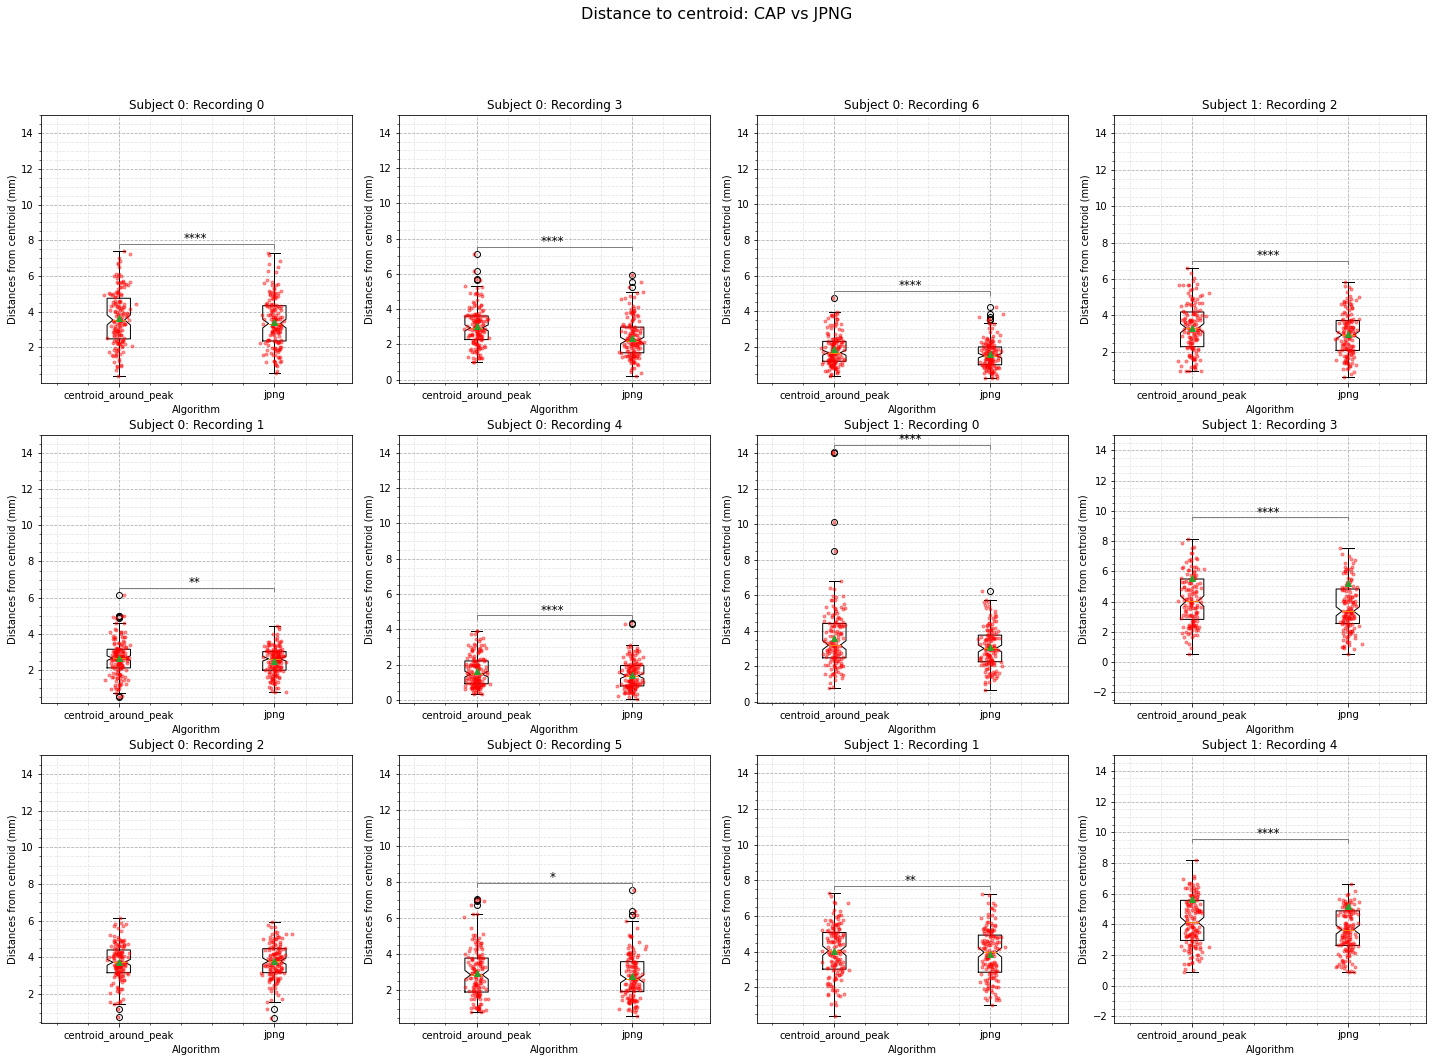

In [61]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
ax_list = list(chain.from_iterable(zip(*axes))) # single iterable list for 2d array
to_plot_df = abl_df[['Subject','Recording','displacements']]

for idx,row in enumerate(to_plot_df.itertuples()):
    displacement_box_plot('Subject '+str(row.Subject), 'Recording ' + str(row.Recording), row.displacements, axis=ax_list[idx])

plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Distance to centroid: CAP vs JPNG", fontsize=16)
plt.savefig(figure_path + '/distancesToCentroid.png')
plt.show()

In [62]:
diff_stats_cols = ['CAP>JPNG','Test name','p','Sig']

In [63]:
def get_diff_stats_cols(df, p_value=0.05):
    """
    Runs the statistical test to compare displacements between CAP & JPNG
    Returns columns (series) containing test results
    """
    diff_col, test_name_col, p_value_col, p_star_col = [], [], [], []
    for _, row in df.iterrows():
        diff_arr, test_name, p = displacement_utils.test_displacements_means_diff_paired(row['displacements'], \
                                                                                         p_val=p_value, quiet=True)
        diff_col.append(diff_arr[0])
        test_name_col.append(test_name)
        p_value_col.append(p)
        p_star_col.append(displacement_utils.get_p_stars(p))
    return pd.Series({'CAP>JPNG':diff_col, 'Test name':test_name_col, 'p':p_value_col, 'Sig':p_star_col})

In [64]:
series = get_diff_stats_cols(ablDF)

In [65]:
for col in diff_stats_cols:
    ablDF[col] = series[col]

In [66]:
stats_cols = stats_cols + diff_stats_cols

In [67]:
summary_stat_cols = summary_stat_cols + diff_stats_cols

## frequency of distances to centroid > 5 mm
We can look at how often the distances to the centroid exceed 5 mm

In [68]:
def disp_above(experiment_name, description, displacements,threshold=5):
    above = displacement_utils.displacements_above_threshold(displacements,threshold,quiet=True)
    return above

In [69]:
ablDF['displacements_above_5'] = ablDF.apply(lambda x: disp_above(x['Experiment Name'], x['Description'], x['displacements'],5),axis=1)

To get a total number of displacements over the threshold for the algorithm, it would be easier to have these counts stored in separate columns (rather than in dicts / tuples that can't be summed easily with pandas)

In [70]:
sel_algos = displacement_utils.select_algos

In [71]:
ablDF['count'] = ablDF.apply(lambda x: len(x['displacements'][sel_algos[0]]), axis=1)

In [72]:
x = ablDF.apply(lambda x: x['displacements_above_5'][sel_algos[0]][0], axis=1)

In [73]:
frame = {'count':ablDF['count']} # Count up the samples in each recording

In [74]:
freq_disp_DF = pd.DataFrame(frame)

In [75]:
disp_suffix = '_disp_gt_5'

In [76]:
for algos in sel_algos:
    freqs = ablDF.apply(lambda x: x['displacements_above_5'][algos][0], axis=1)
    freq_disp_DF = pd.concat([freq_disp_DF,freqs.rename(algos+disp_suffix)],axis=1)

In [77]:
print('Frequency of displacements over 5 mm over all considered ablation recordings:')
for algo in sel_algos:
    print('\t' + algo + ' : ' \
          + str(round(freq_disp_DF[algo+disp_suffix].sum()/freq_disp_DF['count'].sum() * 100, 2)) + '%')

Frequency of displacements over 5 mm over all considered ablation recordings:
	centroid_around_peak : 13.55%
	jpng : 9.18%


## Compare variances

In [78]:
def get_equal_variance(experiment_name, description, displacements, algos):
    p_val = 0.05
    equal_vars = test_displacements_variances_equal(displacements,algo_pairs, p_val)
    

In [79]:
ablDF['cap_jpng_equal_var'] = ablDF.apply(lambda x: displacement_utils.test_displacements_variances_equal(x['displacements'], 
                                                           [sel_algos]),axis=1)

In [80]:
cols_disp = ['Experiment Name','Description'] + stats_cols + ['cap_jpng_equal_var']

In [81]:
ablDF.to_csv(export_path+'/ablLocs_stats.csv', columns=cols_disp,index=False)

In [82]:
summary_disp = ['Subject','Recording'] + summary_stat_cols

In [83]:
abl_df = ablDF[summary_disp].rename(columns={'mean_dist_centroid_around_peak':'CAP mean', 'std_centroid_around_peak':'CAP std',\
                              'mean_dist_jpng':'JPNG mean', 'std_jpng':'JPNG std'})
abl_df.to_csv(export_path+'/distance_to_centroid_stats.csv', float_format='%.2g',index=False)

## format results csv for latex import
The stats csv table has spaces in column names and unnecessary information that can be omitted or abbreviated. Experiment names and descriptions can be represented with numbers, standard deviations can be placed into the same column as the means (with a plus-minus symbol separating them), etc.

In [84]:
subj = list(subj_recording.keys())

In [85]:
abl_df = abl_df.rename(columns={'Experiment Name':'expmt','Test name':'Test', 'CAP mean':'cap_mean',\
                                'CAP std':'cap_std', 'JPNG mean':'jpng_mean', \
                                'JPNG std':'jpng_std'}) # Get rid of spaces

In [86]:
abl_df_brief = abl_df[['Subject','Recording','cap_mean', 'cap_std', 'jpng_mean','jpng_std', 'CAP>JPNG', 'Test', 'p',\
                      'Sig']]

In [87]:
print('Distance to Centroid statistics: CAP and JPNG')
display(abl_df_brief)

Distance to Centroid statistics: CAP and JPNG


,Subject,Recording,cap_mean,cap_std,jpng_mean,jpng_std,CAP>JPNG,Test,p,Sig
0,0,0,3.667502,1.504278,3.415068,1.405725,1.0,Paired-t,4.383684e-07,****
1,0,1,2.631086,0.961909,2.484129,0.756830,1.0,Wilcoxon,9.153422e-03,**
2,0,2,3.744576,1.018724,3.779263,0.958624,0.0,Paired-t,2.317003e-01,ns
3,0,3,3.012864,1.108628,2.383533,1.124991,1.0,Wilcoxon,2.385639e-15,****
4,0,4,1.637320,0.874515,1.428508,0.803342,1.0,Wilcoxon,2.333010e-05,****
5,0,5,2.983305,1.416574,2.804063,1.275201,1.0,Wilcoxon,1.961768e-02,*
6,0,6,1.863212,0.880504,1.579797,0.776645,1.0,Wilcoxon,3.426646e-09,****
7,1,0,3.617476,1.916582,3.085643,1.131081,1.0,Wilcoxon,4.556517e-07,****
8,1,1,4.034543,1.416942,3.899622,1.409000,1.0,Paired-t,2.281733e-03,**
9,1,2,3.326334,1.321069,2.963465,1.174177,1.0,Paired-t,3.046099e-09,****


In [88]:
abl_df_brief=abl_df_brief.rename(columns={'CAP>JPNG':'cap_gt_jpng'})

In [89]:
to_round = ['cap_mean', 'cap_std', 'jpng_mean', 'jpng_std']

In [90]:
for col in to_round:
    abl_df_brief[col] = abl_df_brief[col].map('{:,.2f}'.format)

In [91]:
abl_df_brief['CAP'] = abl_df_brief.apply(lambda x: str(x['cap_mean']) + r'\pm' + str(x['cap_std']),axis=1)

In [92]:
abl_df_brief['JPNG'] = abl_df_brief.apply(lambda x: str(x['jpng_mean']) + r'\pm' + str(x['jpng_std']),axis=1)

Put a bold signifier (\textbf) around the mean if the difference is significant. Note we encode these as raw strings to avoid the this being interpreted as a "tab".

In [93]:
for idx,row in abl_df_brief.iterrows():
    cap_larger = abl_df_brief.loc[idx,'cap_gt_jpng']
    sig = abl_df_brief.loc[idx,'Sig']
    if cap_larger and sig != 'ns':
        expr = abl_df_brief.loc[idx,'JPNG']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        abl_df_brief.loc[idx,'JPNG'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]
    elif not cap_larger and sig != 'ns':
        expr = abl_df_brief.loc[idx,'CAP']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        abl_df_brief.loc[idx,'CAP'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]

In [94]:
abl_df_brief.drop(columns=['cap_mean','cap_std','jpng_mean','jpng_std','cap_gt_jpng'],inplace=True)

In [95]:
abl_df_tex = abl_df_brief[['Subject','Recording','CAP','JPNG','Test','p','Sig']]

In [96]:
abl_df_tex.to_csv(export_path+'/distance_to_centroid_tex.csv', encoding='ascii',float_format='%.2g',index=False)

# Look at successive tip distances
Tip-to-tip distances are expected to be small as they are sampled around every 30 ms for the HM sequence. Large jumps may indicate an issue with the signal or the algorithm.

In [97]:
ablCoordsDF = ablationsDF

In [98]:
for algo in sel_algos:
    ablCoordsDF[algo+'_deltas'] = ablCoordsDF.apply(lambda x: 
                                                    displacement_utils.get_delta_distances(x[algo+'_tipCoords']),
                                                    axis=1)

In [99]:
def delta_plot_refactor(experiment_name, description, deltas, algos, show_scatter=True, axis=None):
    plot = None
    if axis is None:
        plot = displacement_utils.plot_displacement_boxplot(deltas, algos, show_scatter, y_label='Distance (mm)',
                                                       set_ymax=None)
    else:
        plot = displacement_utils.plot_displacement_boxplot(deltas, algos, show_scatter, y_label='Distance (mm)',
                                                       set_ymax=None, plot=axis)
    title = experiment_name + ': ' + description + ' successive distances'
    if axis is None:
        plot.title(title)
        plot.savefig(figure_path+'/dispBoxPlot_'+title+'.png')
        plot.show()
    else:
        axis.set_title(title)

In [100]:
ablCoordsDF['Subject'] = ablCoordsDF.apply(lambda x: list(subj_recording.keys()).index(x['Experiment Name']), axis=1)
ablCoordsDF['Recording'] = ablCoordsDF.apply(lambda x: subj_recording[x['Experiment Name']].index(x['Description']), axis=1)

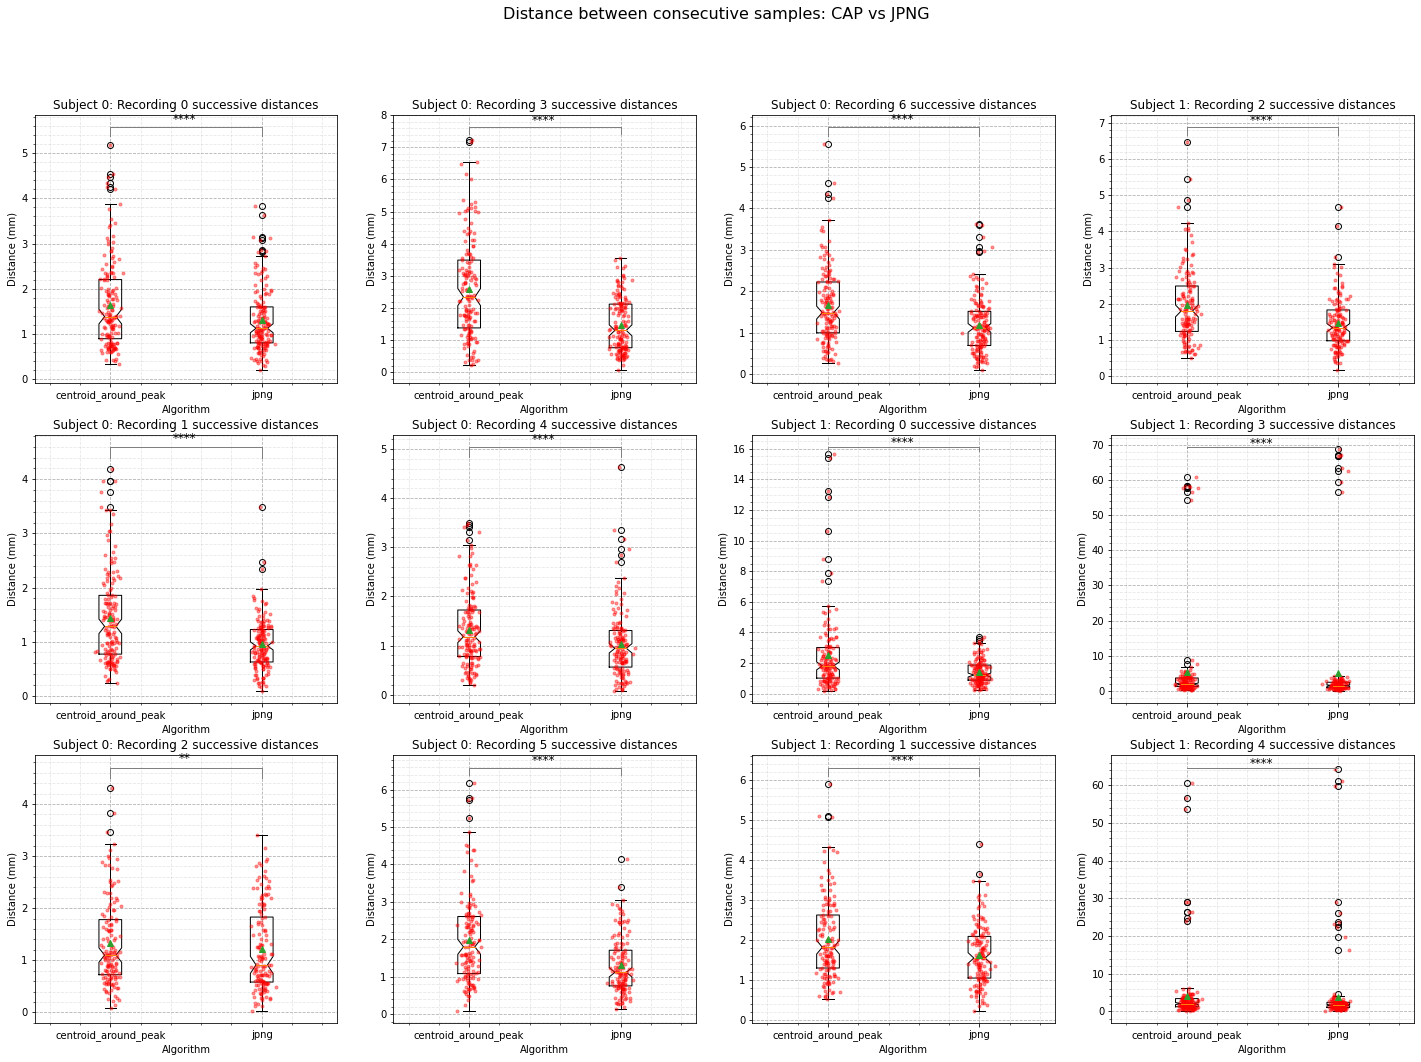

In [101]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
ax_list = list(chain.from_iterable(zip(*axes))) # single iterable list for 2d array
delta_cols =  [algo+'_deltas' for algo in sel_algos]
to_plot_df = ablCoordsDF[['Subject','Recording'] + delta_cols]

for idx,row in enumerate(to_plot_df.itertuples()):
    delta_arrs = [getattr(row,delta_cols[0]),getattr(row,delta_cols[1])]
    delta_plot_refactor('Subject '+str(row.Subject), 'Recording ' + str(row.Recording), delta_arrs, algos=sel_algos,\
                        axis=ax_list[idx])

plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Distance between consecutive samples: CAP vs JPNG", fontsize=16)
plt.savefig(figure_path+'/successiveDistances-boxPlots.png')
plt.show()

Store statistics on successive tip distances

In [102]:
summary_stats_cols = []
for algo in sel_algos:
    ablCoordsDF['median_' + algo + '_deltas'] = ablCoordsDF.apply(lambda x: np.median(x[algo+'_deltas']), axis=1)
    colName = shorten[algo].upper() + ' mean'
    ablCoordsDF[colName] = ablCoordsDF.apply(lambda x: np.mean(x[algo+'_deltas']), axis=1)
    summary_stats_cols.append(colName)
    colName = shorten[algo].upper() +' std'
    summary_stats_cols.append(colName)
    ablCoordsDF[colName] = ablCoordsDF.apply(lambda x: np.std(x[algo+'_deltas'], ddof=1),axis=1)

In [103]:
diff_stats_cols = ['CAP>JPNG','Test name','p','Sig']

In [104]:
def get_delta_diff_stats_cols(df, col1='centroid_around_peak_deltas', col2='jpng_deltas', compare_label='CAP>JPNG', p_value=0.05, prefix=''):
    """
    Runs the statistical test to compare values between CAP & JPNG
    Returns columns (series) containing test results
    """
    diff_col, test_name_col, p_value_col, p_star_col = [], [], [], []
    for _, row in df.iterrows():
        diff_arr, test_name, p = displacement_utils.test_displacements_means_diff_paired([row[col1], \
                                                                                         row[col2]], p_val=p_value,\
                                                                                        quiet=True)
        diff_col.append(diff_arr[0])
        test_name_col.append(test_name)
        p_value_col.append(p)
        p_star_col.append(displacement_utils.get_p_stars(p))
    return pd.Series({prefix+compare_label:diff_col, prefix+'Test name':test_name_col, prefix+'p':p_value_col, prefix+'Sig':p_star_col})

In [105]:
series = get_delta_diff_stats_cols(ablCoordsDF)
for col in diff_stats_cols:
    ablCoordsDF[col] = series[col]

In [106]:
summary_stats_cols = summary_stats_cols + diff_stats_cols

In [107]:
cols_disp = ['Subject', 'Recording'] + summary_stats_cols
print('Successive distance statistics: CAP and JPNG')
display(ablCoordsDF[cols_disp])

Successive distance statistics: CAP and JPNG


,Subject,Recording,CAP mean,CAP std,JPNG mean,JPNG std,CAP>JPNG,Test name,p,Sig
0,0,0,1.641710,0.970745,1.297294,0.699829,1.0,Wilcoxon,1.032279e-07,****
1,0,1,1.440842,0.850243,0.949208,0.474563,1.0,Wilcoxon,6.221271e-14,****
2,0,2,1.330340,0.822650,1.216044,0.806019,1.0,Wilcoxon,2.015231e-03,**
3,0,3,2.599996,1.542852,1.479414,0.831169,1.0,Wilcoxon,4.391698e-16,****
4,0,4,1.322963,0.759524,1.031433,0.691105,1.0,Wilcoxon,4.812517e-07,****
5,0,5,1.993395,1.192218,1.304732,0.758427,1.0,Wilcoxon,1.678352e-11,****
6,0,6,1.668536,0.921967,1.194540,0.685801,1.0,Wilcoxon,5.231312e-13,****
7,1,0,2.509575,2.607361,1.404327,0.766165,1.0,Wilcoxon,1.317349e-13,****
8,1,1,2.032311,1.011166,1.633305,0.766043,1.0,Wilcoxon,4.718855e-09,****
9,1,2,1.964437,1.033529,1.453708,0.722721,1.0,Wilcoxon,5.709024e-13,****


In [108]:
ablCoordsDF.to_hdf(export_path+'/ablationTipJumpsDF.hdf5',key='ablTjDF')
ablCoordsDF.to_csv(export_path+'/tip_delta_stats.csv', columns=cols_disp, float_format='%.2g', index=False)

## export for latex
Simplify the table for publication - no spaces, shorten names, use +/- symbol, remove unnecessary columns, etc. Use the csvsimple package to import these into latex.

In [109]:
tip_delta_df = ablCoordsDF[cols_disp].rename(columns={'Experiment Name':'expmt','Test name':'Test', \
                                                      'CAP mean':'cap_mean', 'CAP std':'cap_std', \
                                                      'JPNG mean':'jpng_mean', 'JPNG std':'jpng_std', \
                                                     'CAP>JPNG':'cap_gt_jpng'})

In [110]:
tip_delta_brief = tip_delta_df[['Subject','Recording','cap_mean', 'cap_std', 'jpng_mean','jpng_std', 'cap_gt_jpng', \
                                'Test', 'p', 'Sig']]

In [111]:
to_round = ['cap_mean', 'cap_std', 'jpng_mean', 'jpng_std']
for col in to_round:
    tip_delta_brief[col] = tip_delta_brief[col].map('{:,.2f}'.format)

In [112]:
tip_delta_brief['CAP'] = tip_delta_brief.apply(lambda x: str(x['cap_mean']) + r'\pm' + str(x['cap_std']),axis=1)
tip_delta_brief['JPNG'] = tip_delta_brief.apply(lambda x: str(x['jpng_mean']) + r'\pm' + str(x['jpng_std']),axis=1)

In [113]:
for idx,row in tip_delta_brief.iterrows():
    cap_larger = tip_delta_brief.loc[idx,'cap_gt_jpng']
    sig = tip_delta_brief.loc[idx,'Sig']
    if cap_larger and sig != 'ns':
        expr = tip_delta_brief.loc[idx,'JPNG']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        tip_delta_brief.loc[idx,'JPNG'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]
    elif not cap_larger and sig != 'ns':
        expr = tip_delta_brief.loc[idx,'CAP']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        tip_delta_brief.loc[idx,'CAP'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]

In [114]:
tip_delta_tex = tip_delta_brief.drop(columns=['cap_mean','cap_std','jpng_mean','jpng_std','cap_gt_jpng'])
tip_delta_tex = tip_delta_tex[['Subject','Recording','CAP','JPNG','Test','p','Sig']]

In [115]:
tip_delta_tex.to_csv(export_path+'/tip_delta_tex.csv', encoding='ascii', float_format='%.2g',index=False)

# Tip directions
## Angle between successive catheter orientations
Here we look at the angles between successive tip vectors (so the angle between the first tip orientation and the next tip orientation in time)

In [116]:
ablCoordsDF['orientation_deltas'] = ablCoordsDF.apply(lambda x: displacement_utils.get_angles_from_coords(x['coords']),axis=1)

In [117]:
def orientation_plot(experiment_name, description, msecs, orientations, show=False):
    plot = displacement_utils.plot_displacements(msecs[1:],orientations,y_label='Tip orientation delta (degrees)')
    title = experiment_name + ': ' + description
    plot.title(title)
    title = 'tipdeltaOrientation_'+experiment_name+'_'+description
    plot.savefig(figure_path+'/'+title+'.png')
    if show:
        plot.show()
    else:
        plot.close()

These plot the orientation delta between successive tip samples over time for each recording. The plots are saved to files. To see them inline, set `show=True` in the call below

In [118]:
out = ablCoordsDF.apply(lambda x: orientation_plot(x['Experiment Name'], x['Description'], x['msecs'],\
                                                   x['orientation_deltas'], show=False),axis=1)

In [119]:
def orientation_box_plot(experiment_name, description, orientations, axis=None):
    plot = None
    if axis is None:
        plot = displacement_utils.plot_displacement_boxplot(orientations,set_ymax=None)
    else:
        plot = displacement_utils.plot_displacement_boxplot(orientations,set_ymax=None, plot=axis)
    title = 'Tip delta orientation ' + experiment_name + ': ' + description
    if axis is None:
        plot.title(title)
        plt_label = experiment_name+'_'+description
        plot.savefig(figure_path+'/orientationDeltaBoxPlot_'+plt_label+'.png')
        plot.show()
    else:
        axis.set_title(title)

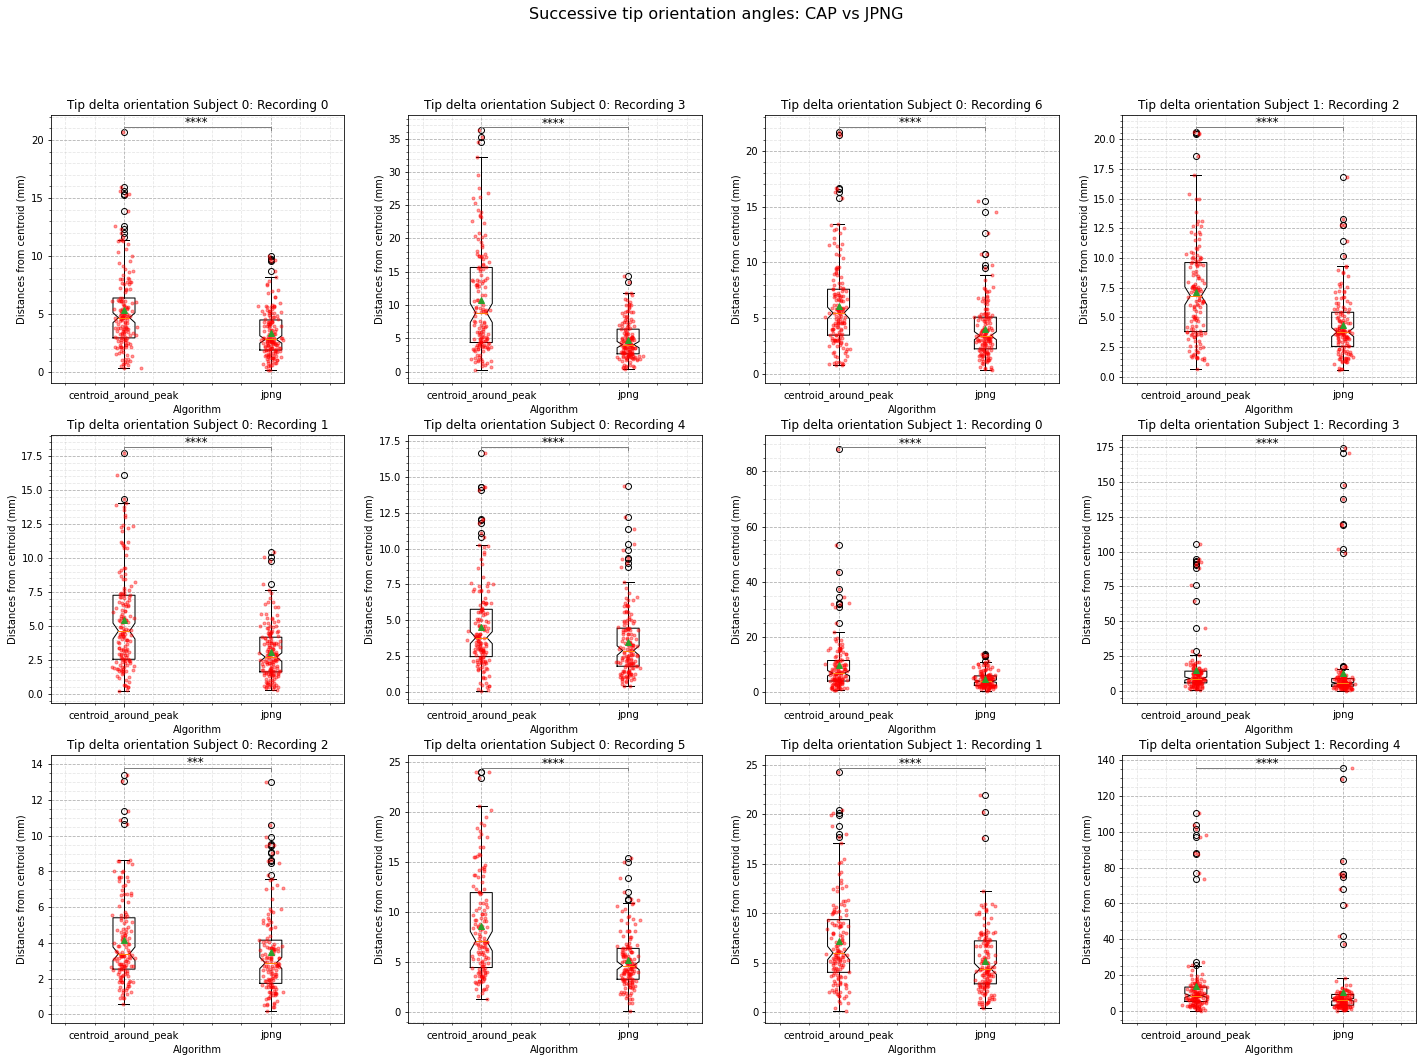

In [120]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
ax_list = list(chain.from_iterable(zip(*axes))) # single iterable list for 2d array
to_plot_df = ablCoordsDF[['Subject','Recording','orientation_deltas']]

for idx,row in enumerate(to_plot_df.itertuples()):
    orientation_box_plot('Subject '+str(row.Subject), 'Recording ' + str(row.Recording), row.orientation_deltas, axis=ax_list[idx])

plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Successive tip orientation angles: CAP vs JPNG", fontsize=16)
plt.savefig(figure_path+'/tipOrientationDeltaBoxPlot.png')
plt.show()

In [121]:
tipOrientationDF = ablCoordsDF[["Subject","Recording"]].copy()
summary_stat_cols = []
prefix='tilt_delta_'

for algo in displacement_utils.select_algos:
    colName = 'mean_tilt_delta_' + shorten[algo]
    summary_stat_cols.append(colName)
    tipOrientationDF[colName] = ablCoordsDF.apply(lambda x: np.mean(x['orientation_deltas'][algo]),axis=1)
    colName = 'std_tilt_delta_' + shorten[algo]
    summary_stat_cols.append(colName)
    tipOrientationDF[colName] = ablCoordsDF.apply(lambda x: np.std(x['orientation_deltas'][algo],ddof=1),axis=1)

In [122]:
ablCoordsDF['cap_orientation_delta'] = ablCoordsDF.apply(lambda x: x['orientation_deltas']['centroid_around_peak'], axis=1)
ablCoordsDF['jpng_orientation_delta'] = ablCoordsDF.apply(lambda x: x['orientation_deltas']['jpng'], axis=1)

In [123]:
tip_delta_diff_stats_cols = [prefix + i for i in diff_stats_cols]

In [124]:
def get_delta_stats_cols(df, col1='centroid_around_peak_deltas', col2='jpng_deltas', compare_label='CAP>JPNG', p_value=0.05, prefix=''):
    """
    Runs the statistical test to compare values between CAP & JPNG
    Returns columns (series) containing test results
    """
    diff_col, test_name_col, p_value_col, p_star_col = [], [], [], []
    for _, row in df.iterrows():
        diff_arr, test_name, p = displacement_utils.test_displacements_means_diff_paired([row[col1], \
                                                                                         row[col2]], p_val=p_value,\
                                                                                         quiet=True)
        diff_col.append(diff_arr[0])
        test_name_col.append(test_name)
        p_value_col.append(p)
        p_star_col.append(displacement_utils.get_p_stars(p))
    return pd.Series({prefix+compare_label:diff_col, prefix+'Test name':test_name_col, prefix+'p':p_value_col, prefix+'Sig':p_star_col})

In [125]:
series = get_delta_stats_cols(ablCoordsDF, col1='cap_orientation_delta',col2='jpng_orientation_delta',prefix=prefix)

In [126]:
for col in tip_delta_diff_stats_cols:
    tipOrientationDF[col] = series[col]

In [127]:
tipOrientation_df = tipOrientationDF.rename(columns={'mean_tilt_delta_cap':'CAP mean', 'std_tilt_delta_cap':'CAP std', \
                                                    'mean_tilt_delta_jpng':'JPNG mean', 'std_tilt_delta_jpng':'JPNG std', \
                                                    'tilt_delta_CAP>JPNG':'CAP>JPNG', 'tilt_delta_Test name':'Test name',\
                                                    'tilt_delta_p':'p', 'tilt_delta_Sig':'Sig'})

In [128]:
tipOrientation_df.to_csv(export_path+'/tipOrientationDelta_stats.csv',float_format='%.2g', index=False)

## format for latex
export table to a format suitable for latex import using csvsimple

In [129]:
tip_orientation = tipOrientationDF.rename(columns={'Experiment Name':'expmt','mean_tilt_delta_cap':'cap_mean',\
                                                   'std_tilt_delta_cap':'cap_std','mean_tilt_delta_jpng':'jpng_mean',\
                                                   'std_tilt_delta_jpng':'jpng_std','tilt_delta_Test name':'Test',\
                                                   'tilt_delta_CAP>JPNG':'cap_gt_jpng','tilt_delta_p':'p', \
                                                   'tilt_delta_Sig':'Sig'})

In [130]:
tip_orientation = tip_orientation[['Subject','Recording','cap_mean', 'cap_std', 'jpng_mean','jpng_std', \
                                   'cap_gt_jpng', 'Test', 'p','Sig']]

In [131]:
to_round = ['cap_mean', 'cap_std', 'jpng_mean', 'jpng_std']
for col in to_round:
    tip_orientation[col] = tip_orientation[col].map('{:,.2f}'.format)

In [132]:
tip_orientation['CAP'] = tip_orientation.apply(lambda x: str(x['cap_mean']) + r'\pm' + str(x['cap_std']),axis=1)
tip_orientation['JPNG'] = tip_orientation.apply(lambda x: str(x['jpng_mean']) + r'\pm' + str(x['jpng_std']),axis=1)

In [133]:
print("Successive tip angles: CAP vs JPNG")
display(tip_orientation)

Successive tip angles: CAP vs JPNG


,Subject,Recording,cap_mean,cap_std,jpng_mean,jpng_std,cap_gt_jpng,Test,p,Sig,CAP,JPNG
0,0,0,5.34,3.50,3.38,2.06,1.0,Wilcoxon,1.428757e-13,****,5.34\pm3.50,3.38\pm2.06
1,0,1,5.43,3.66,3.09,1.98,1.0,Wilcoxon,5.383000e-16,****,5.43\pm3.66,3.09\pm1.98
2,0,2,4.17,2.49,3.49,2.44,1.0,Wilcoxon,4.713146e-04,***,4.17\pm2.49,3.49\pm2.44
3,0,3,10.70,8.03,4.80,2.89,1.0,Wilcoxon,1.069502e-16,****,10.70\pm8.03,4.80\pm2.89
4,0,4,4.52,3.12,3.47,2.45,1.0,Wilcoxon,4.377035e-05,****,4.52\pm3.12,3.47\pm2.45
5,0,5,8.62,5.21,5.18,2.79,1.0,Wilcoxon,3.952818e-14,****,8.62\pm5.21,5.18\pm2.79
6,0,6,6.14,3.87,4.01,2.56,1.0,Wilcoxon,4.963418e-13,****,6.14\pm3.87,4.01\pm2.56
7,1,0,9.75,10.72,4.59,2.87,1.0,Wilcoxon,3.283013e-16,****,9.75\pm10.72,4.59\pm2.87
8,1,1,7.14,4.54,5.20,3.49,1.0,Wilcoxon,1.372693e-08,****,7.14\pm4.54,5.20\pm3.49
9,1,2,7.13,4.13,4.34,2.69,1.0,Wilcoxon,1.024082e-14,****,7.13\pm4.13,4.34\pm2.69


In [134]:
for idx,row in tip_orientation.iterrows():
    cap_larger = tip_orientation.loc[idx,'cap_gt_jpng']
    sig = tip_orientation.loc[idx,'Sig']
    if cap_larger and sig != 'ns':
        expr = tip_orientation.loc[idx,'JPNG']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        tip_orientation.loc[idx,'JPNG'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]
    elif not cap_larger and sig != 'ns':
        expr = tip_orientation.loc[idx,'CAP']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        tip_orientation.loc[idx,'CAP'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]

In [135]:
tip_orientation.drop(columns=['cap_mean','cap_std','jpng_mean','jpng_std','cap_gt_jpng'],inplace=True)
tip_orientation_delta_tex = tip_orientation[['Subject','Recording','CAP','JPNG','Test','p','Sig']]

In [136]:
tip_orientation_delta_tex.to_csv(export_path+'/tip_orientation_delta_tex.csv', encoding='ascii', float_format='%.2g',index=False)

## Orientation angles from mean tip vectors
Here, instead of computing the angles between successive tip vectors, we compare each tip vector to the mean tip vector from that recording and algorithm

In [137]:
tipOrientationDF = ablCoordsDF[["Subject","Recording"]].copy()

In [138]:
ablCoordsDF['tip_unit_vecs'] = ablCoordsDF.apply(lambda x: displacement_utils.get_unit_vectors(x['coords']),axis=1)

In [139]:
def get_mean_vecs(unit_vec_dicts):
    algo_vecs = {}
    for (algo,vecs) in unit_vec_dicts.items():
        algo_vecs[algo] = np.mean(vecs,axis=0)
    return algo_vecs 

In [140]:
ablCoordsDF['mean_tip_unit_vecs'] = ablCoordsDF.apply(lambda x: get_mean_vecs(x['tip_unit_vecs']),axis=1)

In [141]:
ablCoordsDF['tip_angles_from_mean'] = ablCoordsDF.apply(lambda x: displacement_utils.get_angles_from_means(x['mean_tip_unit_vecs'],x['tip_unit_vecs']),axis=1)

In [142]:
def tilt_from_mean_plot(experiment_name, description, msecs, orientations, show=False):
    plot = displacement_utils.plot_displacements(msecs,orientations,y_label='Tip tilt from mean (degrees)')
    title = 'Tip tilt from mean ' + experiment_name + ': ' + description
    plot.title(title)
    title = 'tipTiltFromMean_'+experiment_name+'_'+description
    plot.savefig(figure_path+'/'+title+'.png')
    if show:
        plot.show()
    else:
        plot.close()

These plot the angle to the mean angle over time for each recording. The plots are saved to files. To see them inline, set `show=True` in the call below

In [143]:
out = ablCoordsDF.apply(lambda x: tilt_from_mean_plot(x['Experiment Name'], x['Description'], x['msecs'],x['tip_angles_from_mean'],show=False),axis=1)

In [144]:
def tip_tilt_box_plot(experiment_name, description, orientations, axis=None):
    plot = None
    if axis is None:
        plot = displacement_utils.plot_displacement_boxplot(orientations,set_ymax=None)
    else:
        plot = displacement_utils.plot_displacement_boxplot(orientations,set_ymax=None, plot=axis)
    title = 'Tip tilt from mean ' + experiment_name + ': ' + description
    if axis is None:
        plot.title(title)       
        subtitle = experiment_name+'_'+description 
        plot.savefig(figure_path+'/tipTiltBoxPlot_'+subtitle+'.png')
        plot.show()
    else:
        axis.set_title(title)

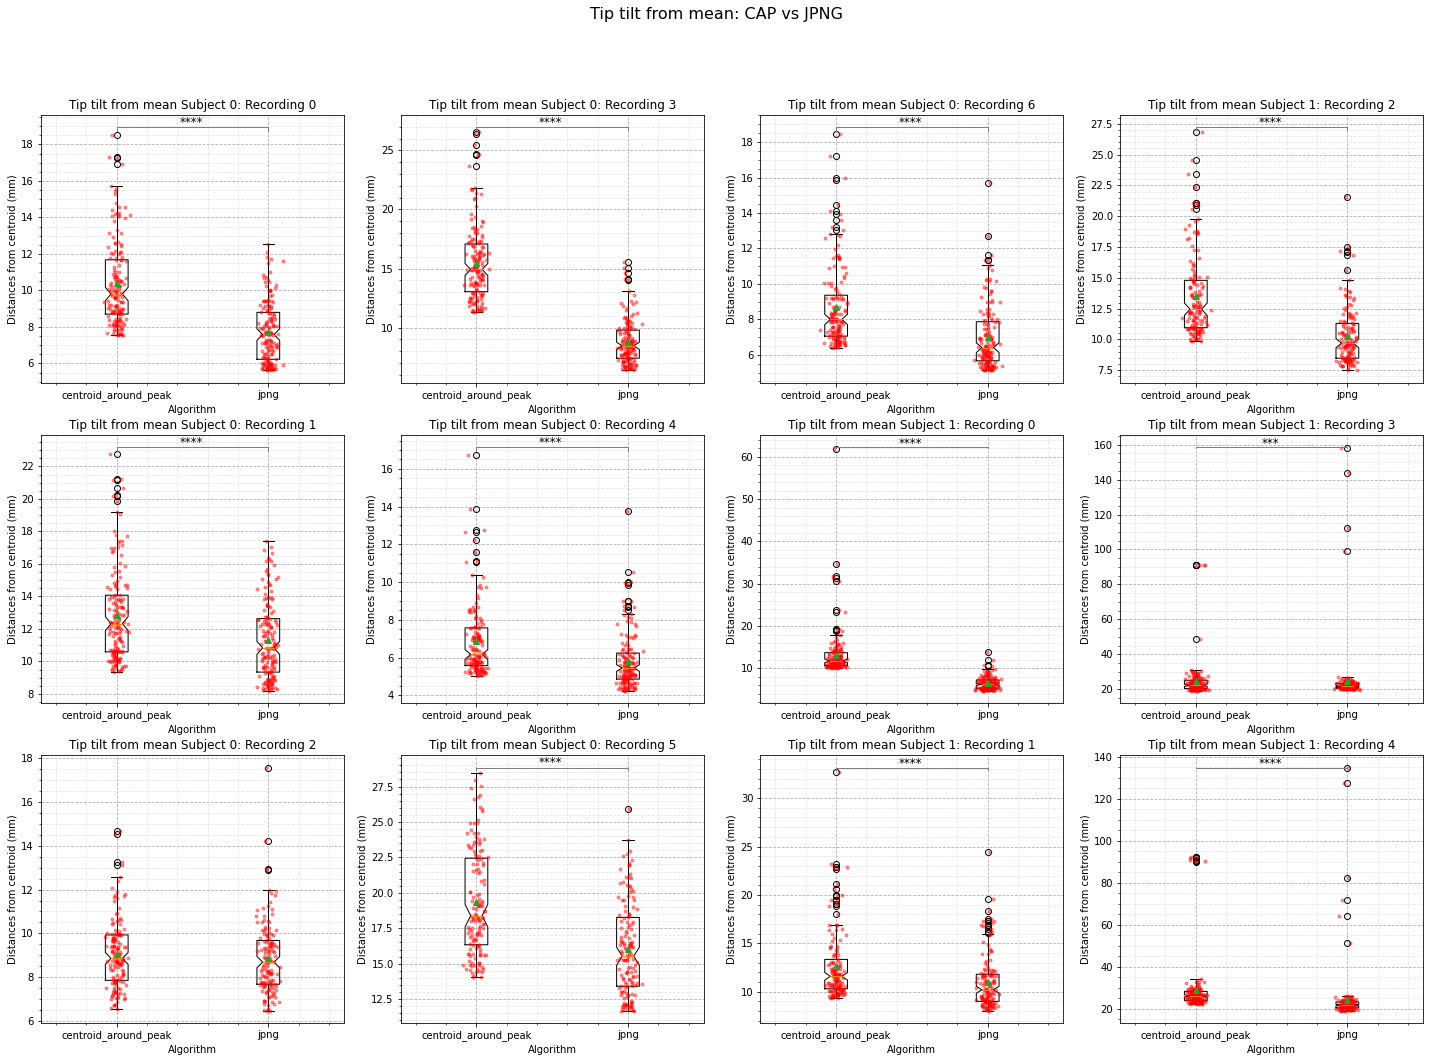

In [145]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(20, 15))
ax_list = list(chain.from_iterable(zip(*axes))) # single iterable list for 2d array
to_plot_df = ablCoordsDF[['Subject','Recording','tip_angles_from_mean']]

for idx,row in enumerate(to_plot_df.itertuples()):
    tip_tilt_box_plot('Subject '+str(row.Subject), 'Recording ' + str(row.Recording), row.tip_angles_from_mean, axis=ax_list[idx])

plt.tight_layout()
fig.subplots_adjust(top=0.88)
fig.suptitle("Tip tilt from mean: CAP vs JPNG", fontsize=16)
plt.savefig(figure_path+'/tipOrientationFromMeanBoxPlot.png')
plt.show()

In [146]:
for algo in displacement_utils.select_algos:
    colName = shorten[algo].upper() + ' mean'
    summary_stat_cols.append(colName)
    tipOrientationDF[colName] = ablCoordsDF.apply(lambda x: np.mean(x['tip_angles_from_mean'][algo]),axis=1)
    colName = shorten[algo].upper() + ' std'
    summary_stat_cols.append(colName)
    tipOrientationDF[colName] = ablCoordsDF.apply(lambda x: np.std(x['tip_angles_from_mean'][algo],ddof=1),axis=1)

In [147]:
ablCoordsDF['cap_tip_tilt_from_mean'] = ablCoordsDF.apply(lambda x: x['tip_angles_from_mean']['centroid_around_peak'], axis=1)
ablCoordsDF['jpng_tip_tilt_from_mean'] = ablCoordsDF.apply(lambda x: x['tip_angles_from_mean']['jpng'], axis=1)

In [148]:
series = get_delta_stats_cols(ablCoordsDF, col1='cap_tip_tilt_from_mean',col2='jpng_tip_tilt_from_mean')

In [149]:
for col in diff_stats_cols:
    tipOrientationDF[col] = series[col]

In [150]:
tipOrientationDF.to_csv(export_path+'/tipTiltFromMean_stats.csv',float_format='%.2g', index=False)

In [151]:
ablCoordsDF.to_hdf(export_path+'/ablationTipJumpsOrientationDF.hdf5',key='ablTjoDF')

## export to latex format
Export tables to csv that can be imported into latex using csvsimple

In [152]:
tip_angle_df = tipOrientationDF.rename(columns={'Experiment Name':'expmt','Test name':'Test', 'CAP mean':'cap_mean', \
                                'CAP std':'cap_std', 'JPNG mean':'jpng_mean', 'JPNG std':'jpng_std', \
                                'CAP>JPNG':'cap_gt_jpng'}) # Get rid of spaces, illegal chars
tip_angle_brief = tip_angle_df[['Subject','Recording','cap_mean', 'cap_std', 'jpng_mean','jpng_std', 'cap_gt_jpng', \
                                'Test', 'p', 'Sig']]

In [153]:
to_round = ['cap_mean', 'cap_std', 'jpng_mean', 'jpng_std']
for col in to_round:
    tip_angle_brief[col] = tip_angle_brief[col].map('{:,.2f}'.format)

In [154]:
tip_angle_brief['CAP'] = tip_angle_brief.apply(lambda x: str(x['cap_mean']) + r'\pm' + str(x['cap_std']),axis=1)
tip_angle_brief['JPNG'] = tip_angle_brief.apply(lambda x: str(x['jpng_mean']) + r'\pm' + str(x['jpng_std']),axis=1)

In [155]:
for idx,row in tip_angle_brief.iterrows():
    cap_larger = tip_angle_brief.loc[idx,'cap_gt_jpng']
    sig = tip_angle_brief.loc[idx,'Sig']
    if cap_larger and sig != 'ns':
        expr = tip_angle_brief.loc[idx,'JPNG']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        tip_angle_brief.loc[idx,'JPNG'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]
    elif not cap_larger and sig != 'ns':
        expr = tip_angle_brief.loc[idx,'CAP']
        pm = expr.index('\pm') # the end brace will be inserted before the plus/minus
        tip_angle_brief.loc[idx,'CAP'] = r'\textbf{' + expr[0:pm] + r'}' + expr[pm:]

In [156]:
tip_angle_brief.drop(columns=['cap_mean','cap_std','jpng_mean','jpng_std','cap_gt_jpng'],inplace=True)
tip_angle_tex = tip_angle_brief[['Subject','Recording','CAP','JPNG','Test','p','Sig']]

In [157]:
tip_angle_tex.to_csv(export_path+'/tipTiltFromMean_tex.csv',encoding='ascii', float_format='%.2g', index=False)

In [158]:
print("Tip angles to mean orientation: CAP vs JPNG")
display(tip_angle_tex)

Tip angles to mean orientation: CAP vs JPNG


,Subject,Recording,CAP,JPNG,Test,p,Sig
0,0,0,10.38\pm2.35,\textbf{7.71}\pm1.66,Wilcoxon,7.471787e-27,****
1,0,1,12.86\pm2.87,\textbf{11.31}\pm2.34,Wilcoxon,7.923591e-21,****
2,0,2,9.08\pm1.58,8.88\pm1.64,Wilcoxon,6.586829e-02,ns
3,0,3,15.49\pm3.20,\textbf{8.80}\pm1.85,Wilcoxon,3.824666e-27,****
4,0,4,6.87\pm1.90,\textbf{5.82}\pm1.49,Wilcoxon,1.044836e-12,****
5,0,5,19.35\pm3.69,\textbf{16.04}\pm3.23,Wilcoxon,3.969052e-24,****
6,0,6,8.71\pm2.31,\textbf{6.99}\pm1.80,Wilcoxon,1.857655e-22,****
7,1,0,13.27\pm5.68,\textbf{6.51}\pm1.55,Wilcoxon,4.900420e-26,****
8,1,1,12.64\pm3.59,\textbf{10.99}\pm2.76,Wilcoxon,8.235260e-19,****
9,1,2,13.51\pm3.32,\textbf{10.30}\pm2.31,Wilcoxon,3.664022e-24,****
